In [1]:
#1. 인물모드 사진을 성공적으로 제작하였다.
#아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.
#2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.
#인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
#3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.
#추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print('슝=3')

슝=3


(533, 559, 3)


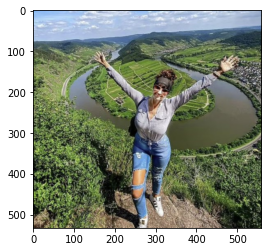

In [3]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/2.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fb53cab1820>)

In [5]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [6]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

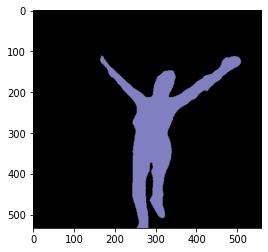

In [8]:
plt.imshow(output)
plt.show()

In [9]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [10]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [11]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [12]:
colormap[15]

array([192, 128, 128])

In [13]:
seg_color = (128,128,192)

(533, 559)


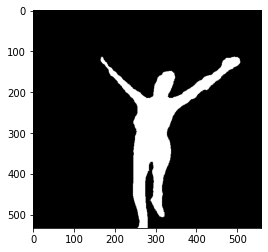

In [14]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

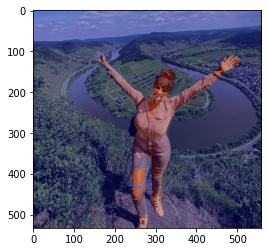

In [15]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

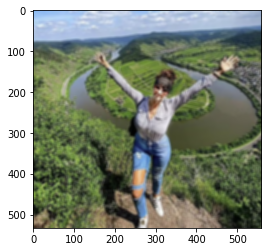

In [16]:
img_orig_blur = cv2.blur(img_orig, (7,7))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

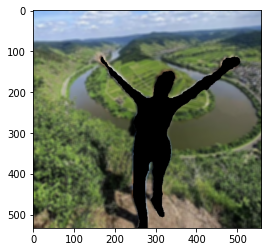

In [17]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

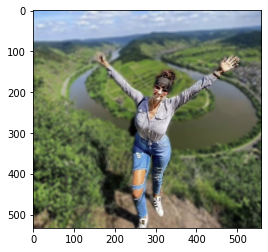

In [18]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

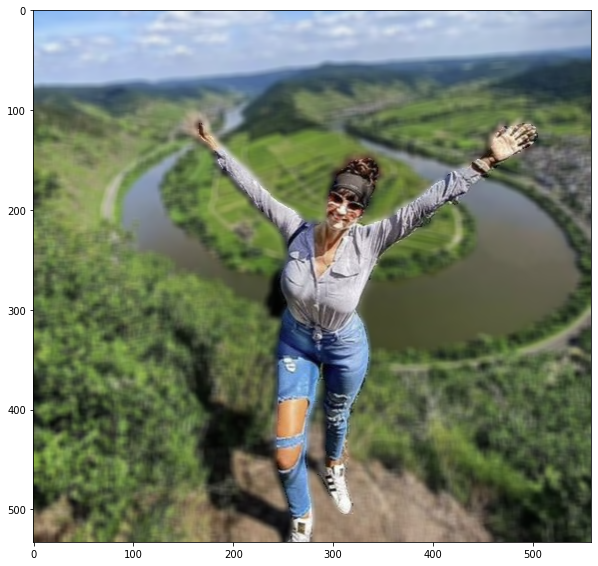

In [19]:
#rs2 = cv2.resize(img_concat, dsize=(0, 0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)  plt.rcParams['figure.figsize']를 이용 크기를 키웠다

plt.rcParams["figure.figsize"] = (10, 10)
cv2.imwrite("aiffel/human_segmentation/images/img_concat.jpg", img_concat)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

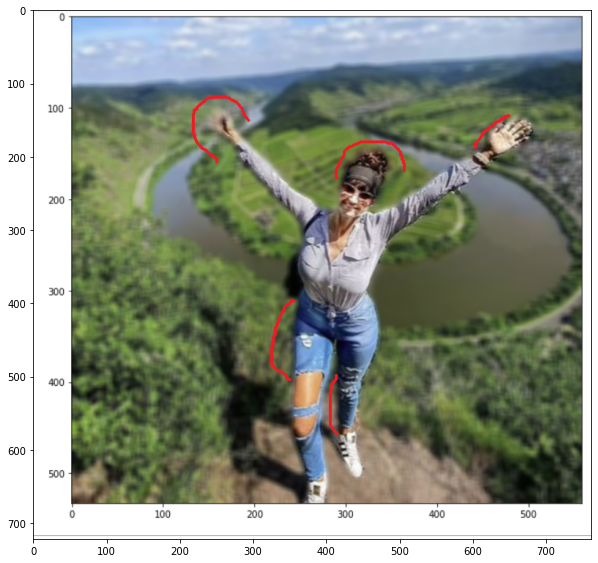

In [20]:
img_path1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/11.png'
img_check = cv2.imread(img_path1)
plt.imshow(cv2.cvtColor(img_check, cv2.COLOR_BGR2RGB))

In [21]:
#너무 사진이 흐려져서 블러를 조절해 봤지만 크게 변화는 없었다. 우선 경계를 잘 인식못하는게 가장 큰 것 같다. 오른쪽 손은 거의 인식하지 못했고
#팔이나 머리카락 엉덩이....등등 경계면의 구분이 힘들다. 
#오류들, 후기는 나중에 찾아서 추가

(500, 500, 3)


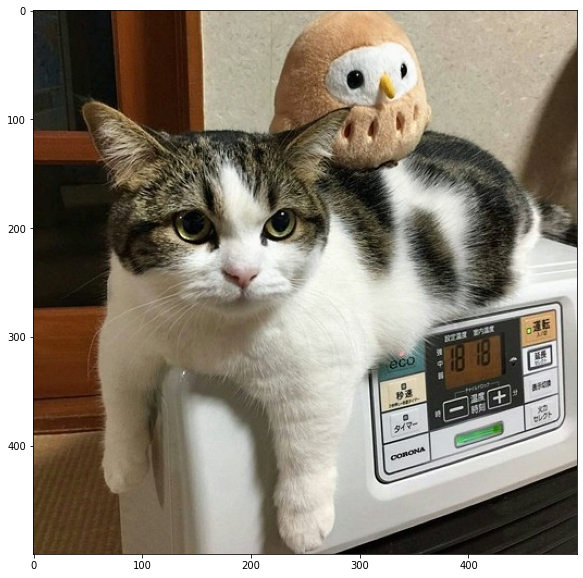

In [22]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/22.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

In [24]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [25]:
segvalues, output = model.segmentAsPascalvoc(img_path)

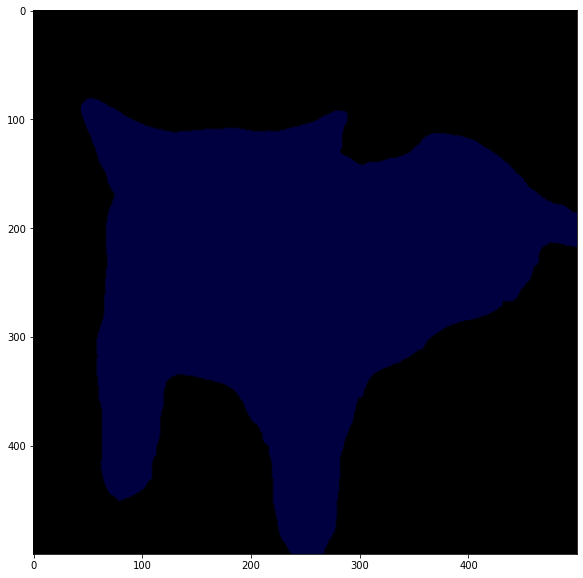

In [26]:
plt.imshow(output)
plt.show()

In [27]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id]) 

background
cat


In [28]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [29]:
colormap[8]

array([64,  0,  0])

In [30]:
seg_color = (0, 0, 64)

(500, 500)


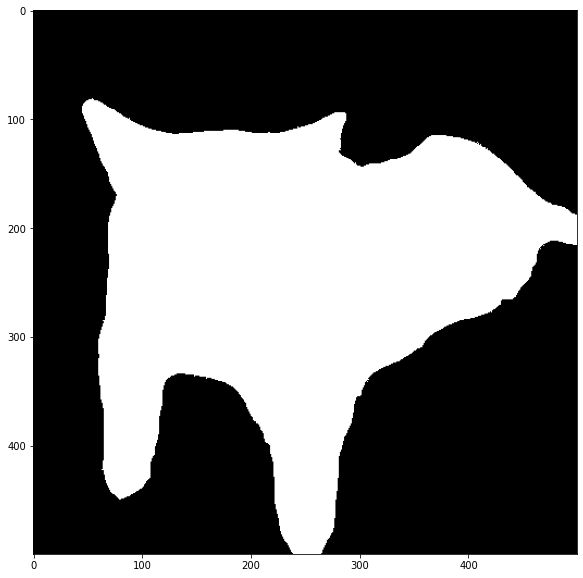

In [31]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

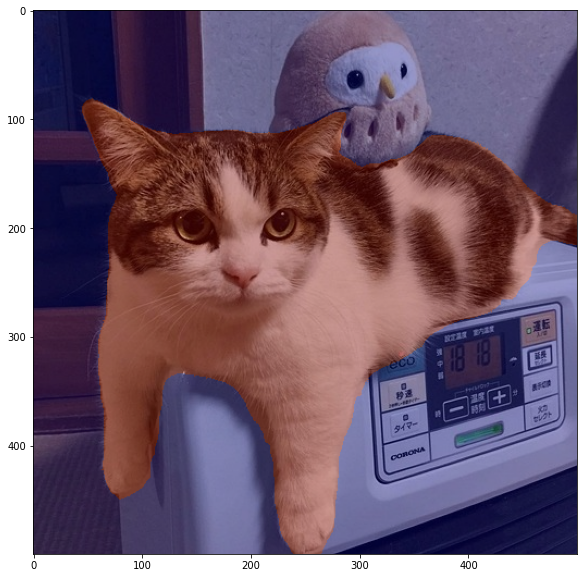

In [32]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

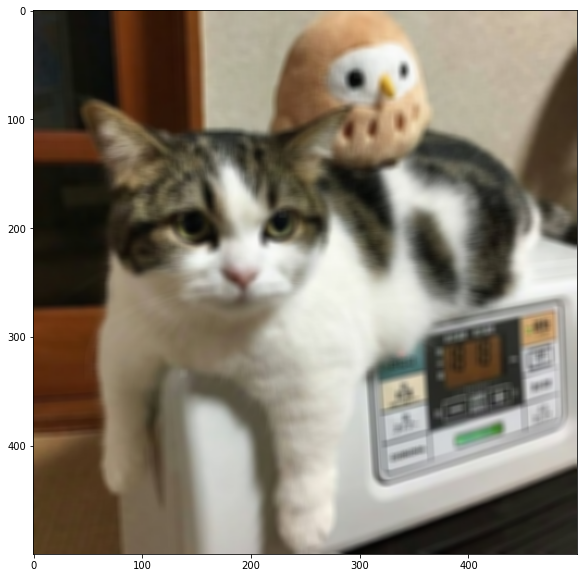

In [33]:
img_orig_blur = cv2.blur(img_orig, (7,7))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

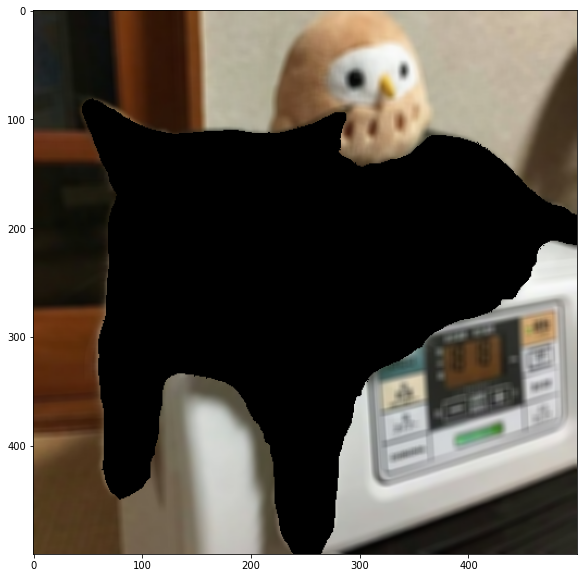

In [34]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

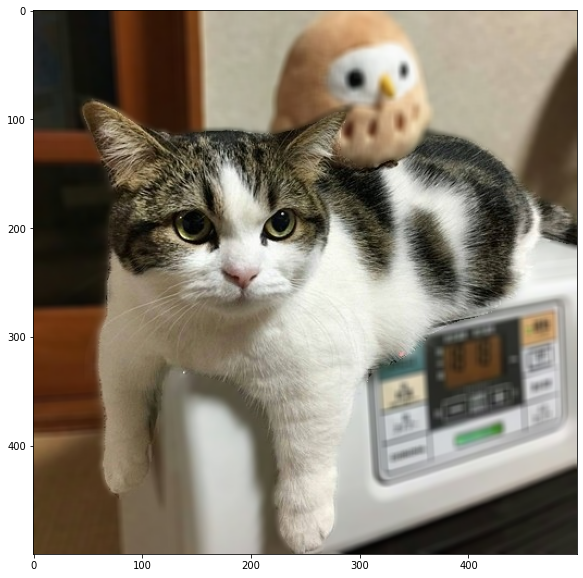

In [35]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
cv2.imwrite("aiffel/human_segmentation/images/img_concat.jpg", img_concat)
plt.show()

In [36]:
#이건 아까전보다 잘된거 같다 이윤 나도 몰라 거리가 가까워서 그런가 등에 인형이 있는 부분 말고는 잘된것같다.

In [37]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/33.jpg'  
img_orig = cv2.imread(img_path)
img_path1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/44.jpg'
img_orig2 = cv2.imread(img_path1)
print(img_orig.shape)
print(img_orig2.shape)

(564, 564, 3)
(1128, 564, 3)


In [38]:
target_size = (img_orig.shape[1], img_orig.shape[0])
orig2_resize = cv2.resize(img_orig2, target_size)
print('all done')

all done


In [39]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

In [40]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [41]:
segvalues, output = model.segmentAsPascalvoc(img_path)

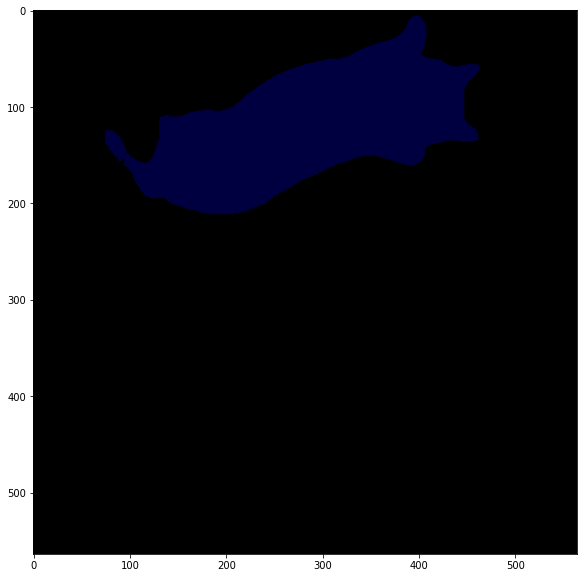

In [42]:
plt.imshow(output)
plt.show()

In [43]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id]) 

background
cat


In [44]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [45]:
colormap[8]

array([64,  0,  0])

In [46]:
seg_color = (0, 0, 64)

(564, 564)


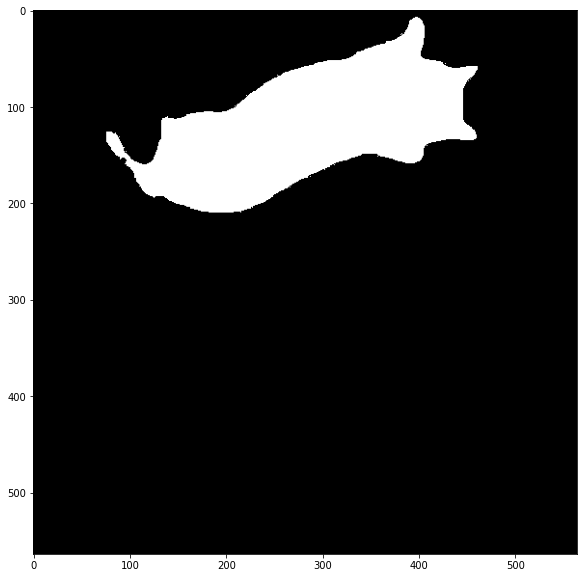

In [47]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

In [48]:
img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)


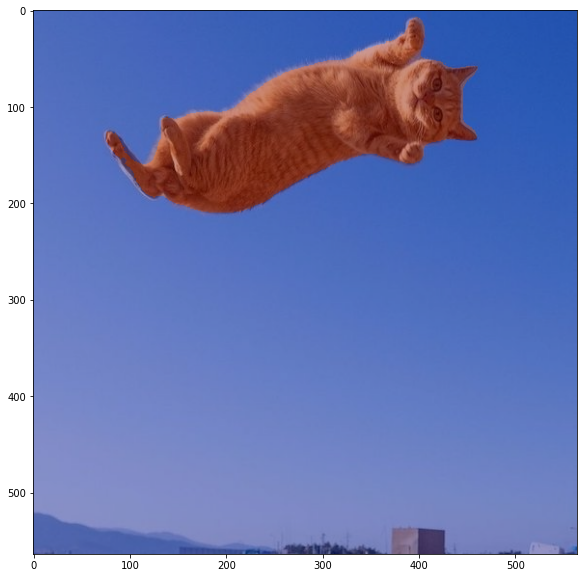

In [49]:
img_show = img_orig.copy()
# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

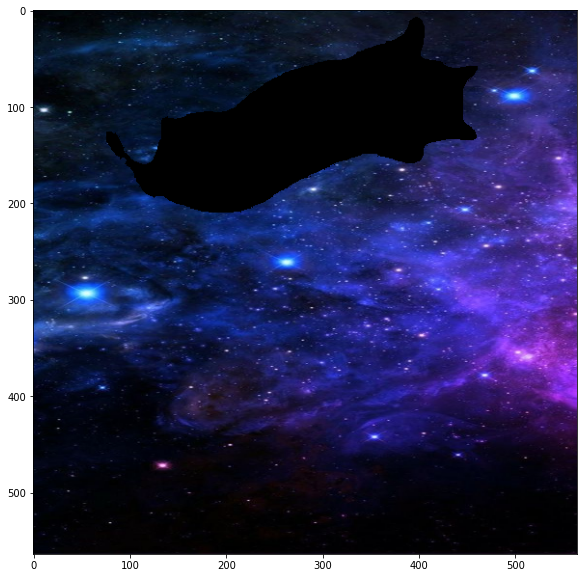

In [50]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(orig2_resize, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [52]:
img_concat = np.where(img_mask_color==255, img_orig, orig2_resize)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
cv2.imwrite("aiffel/human_segmentation/images/img_concat.jpg", img_concat)
plt.show()